In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from functools import partial

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Creating dataset

In [ ]:
#choose which dictionary to use
choice =        'logfilter' #'mfcc'#
useDelta =  False

data = {}

#retrieving of used values for the computation of mfcc
with open('variables/mfccValues.pkl', 'rb') as f:  
    values = pickle.load(f)
    
selected = 0

if choice == 'mfcc':
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/mfccDictDD'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/mfccDict'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #loading in usedDict of the mfcc dict
        with open(name, 'rb') as f: 
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

elif choice == 'logfilter':
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/logfiltDictDD'+functions.getName(index)+'[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/logfiltDict'+functions.getName(index)+'[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #saving in usedDict of the logfilter dict
        with open(name, 'rb') as f:  
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

In [30]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
usedLabels = words

usedLabels.append('silence')

unknownLabels = list(data['Train'].keys())
for key in usedLabels:
    try:
        unknownLabels.remove(key)
    except:
        print(key, ' not in used')

In [31]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    data,
    usedLabels,
    unknownLabels,
    with_unknown = False,
    scalerType = 'robust',
    depth = (len(data['Train'][words[0]].shape)-3)*2 + 1,
    unknown_percentage = 0.3)

print()


Wall time: 16.8 s


In [32]:
%reset -f 
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([0])")

<IPython.core.display.Javascript object>

# Import data

In [3]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [4]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.9 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 15
epochSGD = 15

epochs = [epoch, epochSGD]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

optimizers = [adam, sgd]

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

titles = ['Adam History', 'SGD History']

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Sequential Models

## Model1

In [4]:
%matplotlib notebook

MODEL1
Using optimizer number 0
Train on 34769 samples, validate on 4203 samples
Epoch 1/15
34769/34769 [==============================] - 17s 483us/step - loss: 1.9212 - acc: 0.3745 - top3_acc: 0.6727 - val_loss: 1.5661 - val_acc: 0.5679 - val_top3_acc: 0.8967
Epoch 2/15
34769/34769 [==============================] - 12s 356us/step - loss: 1.1436 - acc: 0.6223 - top3_acc: 0.8893 - val_loss: 1.5800 - val_acc: 0.6307 - val_top3_acc: 0.8806
Epoch 3/15
34769/34769 [==============================] - 12s 356us/step - loss: 0.8486 - acc: 0.7266 - top3_acc: 0.9270 - val_loss: 2.1167 - val_acc: 0.7059 - val_top3_acc: 0.8580
Epoch 4/15
34769/34769 [==============================] - 12s 355us/step - loss: 0.7202 - acc: 0.7713 - top3_acc: 0.9382 - val_loss: 4.0107 - val_acc: 0.5615 - val_top3_acc: 0.7409
Epoch 5/15
34769/34769 [==============================] - 12s 351us/step - loss: 0.6416 - acc: 0.8002 - top3_acc: 0.9456 - val_loss: 2.5678 - val_acc: 0.7271 - val_top3_acc: 0.8349
Epoch 6/15
347

<IPython.core.display.Javascript object>


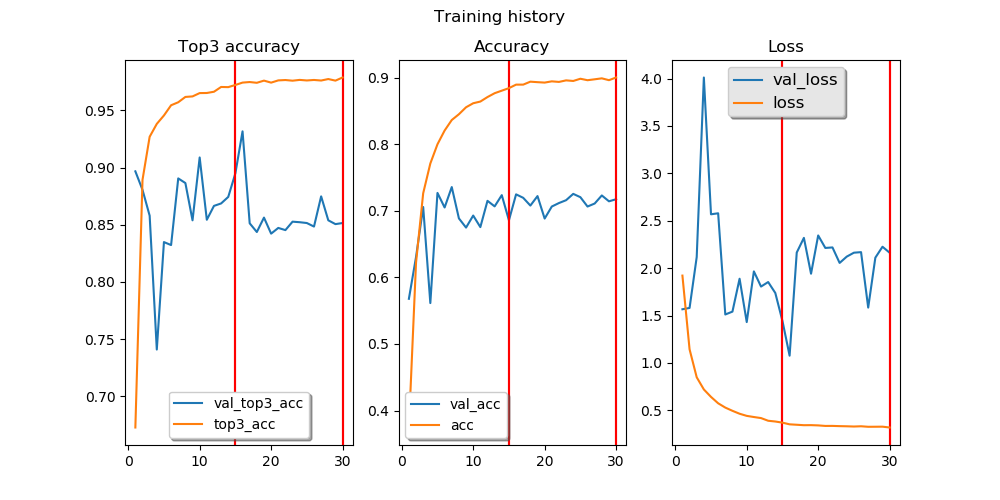

Normalized confusion matrix


<IPython.core.display.Javascript object>


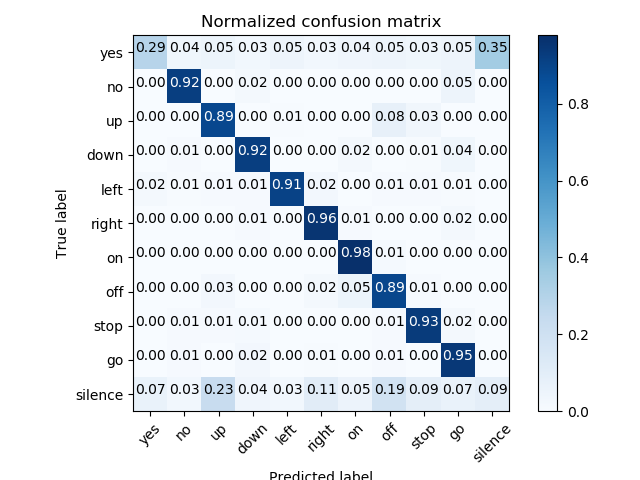

4574/4574 [==============================] - 1s 155us/step
Precision:  71.64 %
Wall time: 6min 11s


In [23]:
%%time
print("MODEL1")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('model1', dataset, labels)

cnn = models.model1(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 54099 samples, validate on 4203 samples
Epoch 1/15
54099/54099 [==============================] - 22s 398us/step - loss: 1.6977 - acc: 0.4204 - top3_acc: 0.7059 - val_loss: 3.3444 - val_acc: 0.4140 - val_top3_acc: 0.7985
Epoch 2/15
54099/54099 [==============================] - 17s 320us/step - loss: 0.9175 - acc: 0.6970 - top3_acc: 0.9173 - val_loss: 2.8851 - val_acc: 0.4808 - val_top3_acc: 0.8392
Epoch 3/15
54099/54099 [==============================] - 17s 320us/step - loss: 0.7107 - acc: 0.7720 - top3_acc: 0.9390 - val_loss: 2.3760 - val_acc: 0.5817 - val_top3_acc: 0.8675
Epoch 4/15
54099/54099 [==============================] - 17s 320us/step - loss: 0.6035 - acc: 0.8079 - top3_acc: 0.9508 - val_loss: 3.2520 - val_acc: 0.5941 - val_top3_acc: 0.8444
Epoch 5/15
54099/54099 [==============================] - 17s 320us/step - loss: 0.5366 - acc: 0.8297 - top3_acc: 0.9581 - val_loss: 2.2972 - val_acc: 0.6548 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


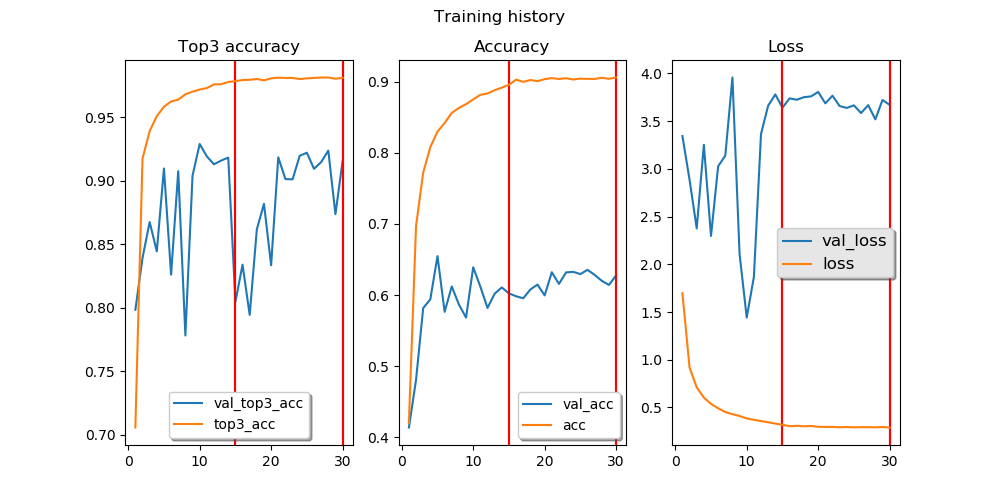

Normalized confusion matrix


<IPython.core.display.Javascript object>


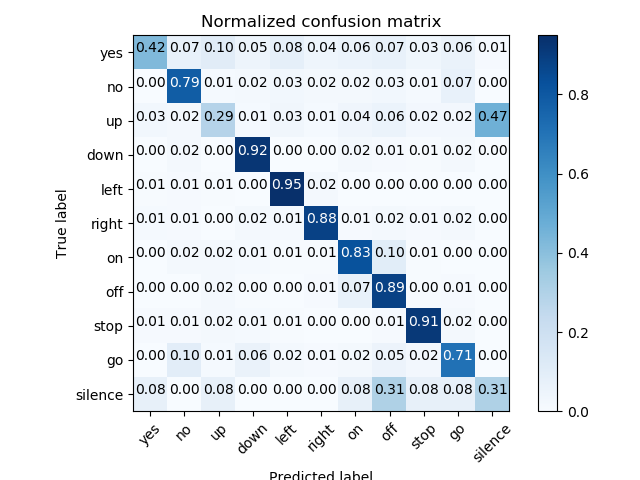

4574/4574 [==============================] - 1s 168us/step
Precision:  63.9 %
Wall time: 8min 43s


In [24]:
%%time
cnn = models.model1(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)
#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

name = 'cnn1.bak'
#cnn.save(dest_directory + name)

## Model2


MODEL2
Using optimizer number 0
Train on 34769 samples, validate on 4203 samples
Epoch 1/15
34769/34769 [==============================] - 33s 953us/step - loss: 2.1944 - acc: 0.2358 - top3_acc: 0.4734 - val_loss: 2.0108 - val_acc: 0.3193 - val_top3_acc: 0.6246
Epoch 2/15
34769/34769 [==============================] - 28s 809us/step - loss: 1.5034 - acc: 0.4838 - top3_acc: 0.7970 - val_loss: 1.0973 - val_acc: 0.6855 - val_top3_acc: 0.9151
Epoch 3/15
34769/34769 [==============================] - 28s 810us/step - loss: 1.1089 - acc: 0.6152 - top3_acc: 0.8938 - val_loss: 0.8087 - val_acc: 0.7540 - val_top3_acc: 0.9481
Epoch 4/15
34769/34769 [==============================] - 28s 809us/step - loss: 0.9388 - acc: 0.6758 - top3_acc: 0.9176 - val_loss: 1.0406 - val_acc: 0.6388 - val_top3_acc: 0.8925
Epoch 5/15
34769/34769 [==============================] - 28s 810us/step - loss: 0.8518 - acc: 0.7077 - top3_acc: 0.9284 - val_loss: 0.6349 - val_acc: 0.8094 - val_top3_acc: 0.9562
Epoch 6/15
34

<IPython.core.display.Javascript object>


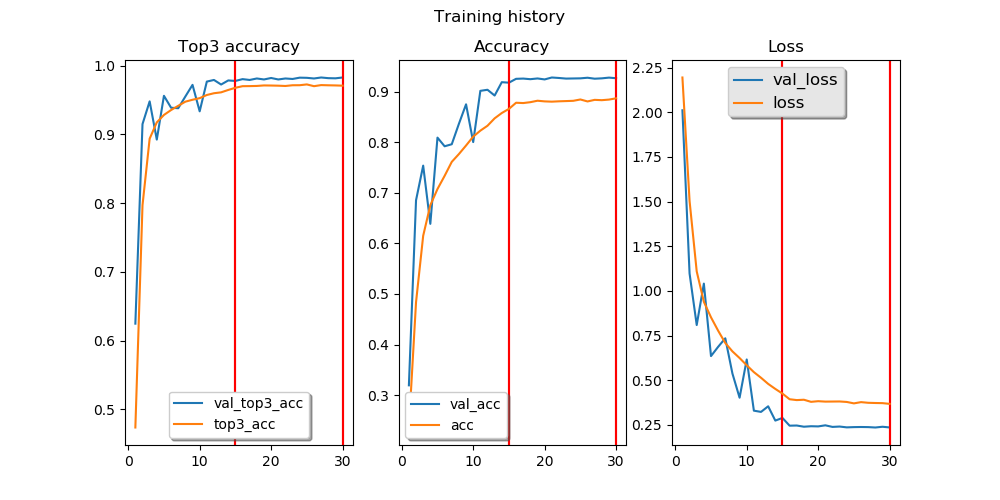

Normalized confusion matrix


<IPython.core.display.Javascript object>


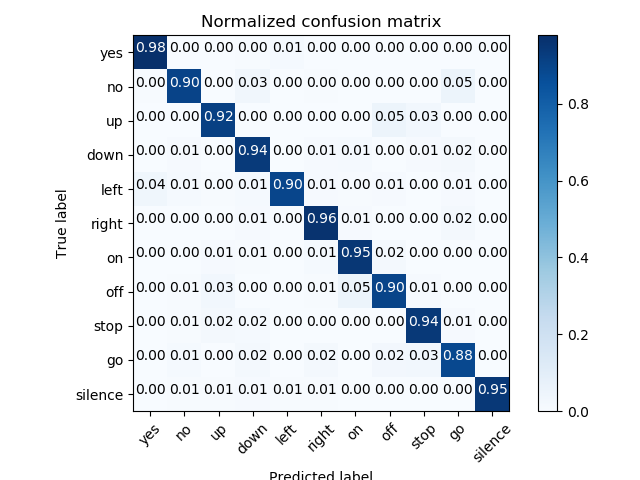

4574/4574 [==============================] - 1s 313us/step
Precision:  92.83 %
Wall time: 14min 12s


In [25]:
%%time
print("\nMODEL2")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('model2', dataset, labels)

cnn = models.model2(inputData,inputLabel, baseDim = 40)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 54099 samples, validate on 4203 samples
Epoch 1/15
54099/54099 [==============================] - 46s 858us/step - loss: 2.2135 - acc: 0.2274 - top3_acc: 0.4670 - val_loss: 2.4625 - val_acc: 0.1351 - val_top3_acc: 0.3538
Epoch 2/15
54099/54099 [==============================] - 41s 753us/step - loss: 1.5131 - acc: 0.4824 - top3_acc: 0.7978 - val_loss: 1.0500 - val_acc: 0.6902 - val_top3_acc: 0.9312
Epoch 3/15
54099/54099 [==============================] - 41s 753us/step - loss: 1.0901 - acc: 0.6269 - top3_acc: 0.8989 - val_loss: 0.7975 - val_acc: 0.7552 - val_top3_acc: 0.9429
Epoch 4/15
54099/54099 [==============================] - 41s 753us/step - loss: 0.9170 - acc: 0.6895 - top3_acc: 0.9207 - val_loss: 0.6546 - val_acc: 0.7966 - val_top3_acc: 0.9622
Epoch 5/15
54099/54099 [==============================] - 41s 753us/step - loss: 0.8033 - acc: 0.7294 - top3_acc: 0.9325 - val_loss: 1.2269 - val_acc: 0.6124 - val_top3_acc: 0.8

<IPython.core.display.Javascript object>


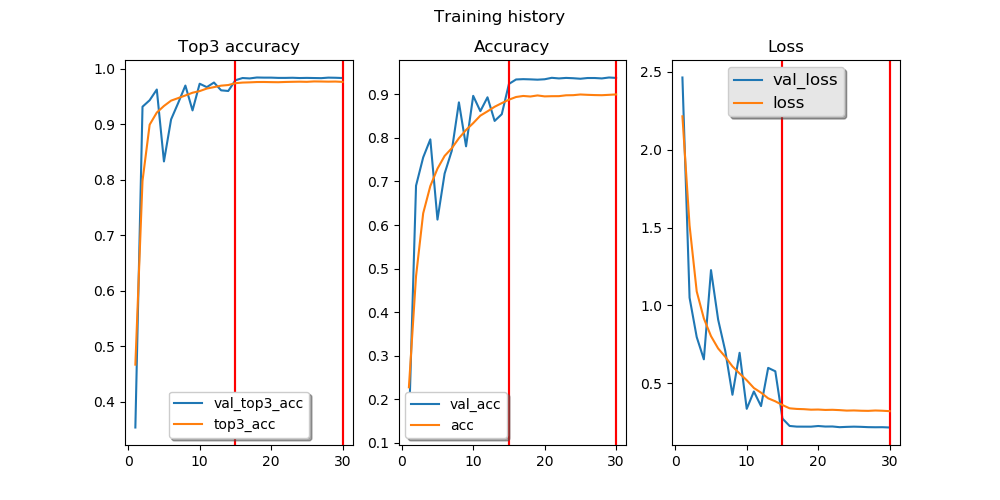

Normalized confusion matrix


<IPython.core.display.Javascript object>


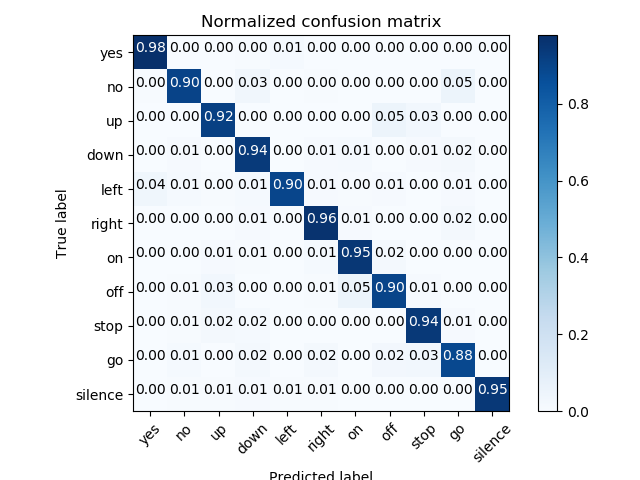

4574/4574 [==============================] - 1s 305us/step
Precision:  93.24 %
Wall time: 20min 21s


In [26]:
%%time
cnn = models.model2(inputData,inputLabel, baseDim = 40)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")
name = 'cnn2.bak'
#cnn.save(dest_directory + name)

## TinyDarknet


TINYDARKNET
Using optimizer number 0
Train on 34769 samples, validate on 4203 samples
Epoch 1/15
34769/34769 [==============================] - 34s 966us/step - loss: 1.5316 - acc: 0.6819 - top3_acc: 0.8622 - val_loss: 0.4664 - val_acc: 0.8789 - val_top3_acc: 0.9676
Epoch 2/15
34769/34769 [==============================] - 26s 743us/step - loss: 0.3974 - acc: 0.8931 - top3_acc: 0.9722 - val_loss: 0.3167 - val_acc: 0.9146 - val_top3_acc: 0.9793
Epoch 3/15
34769/34769 [==============================] - 26s 743us/step - loss: 0.3021 - acc: 0.9166 - top3_acc: 0.9790 - val_loss: 0.2816 - val_acc: 0.9205 - val_top3_acc: 0.9826
Epoch 4/15
34769/34769 [==============================] - 26s 750us/step - loss: 0.2580 - acc: 0.9300 - top3_acc: 0.9835 - val_loss: 0.2646 - val_acc: 0.9327 - val_top3_acc: 0.9817
Epoch 5/15
34769/34769 [==============================] - 26s 752us/step - loss: 0.2312 - acc: 0.9357 - top3_acc: 0.9849 - val_loss: 0.2556 - val_acc: 0.9341 - val_top3_acc: 0.9819
Epoch 6/

<IPython.core.display.Javascript object>


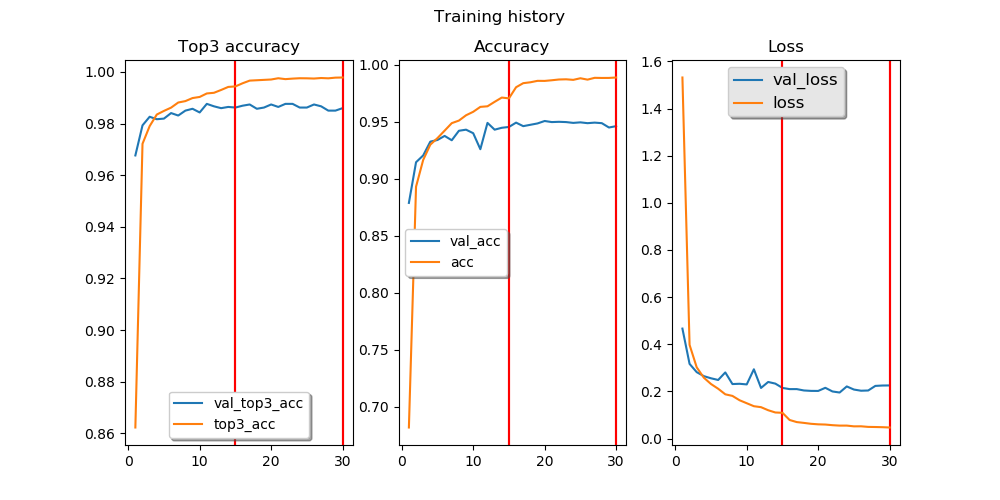

Normalized confusion matrix


<IPython.core.display.Javascript object>


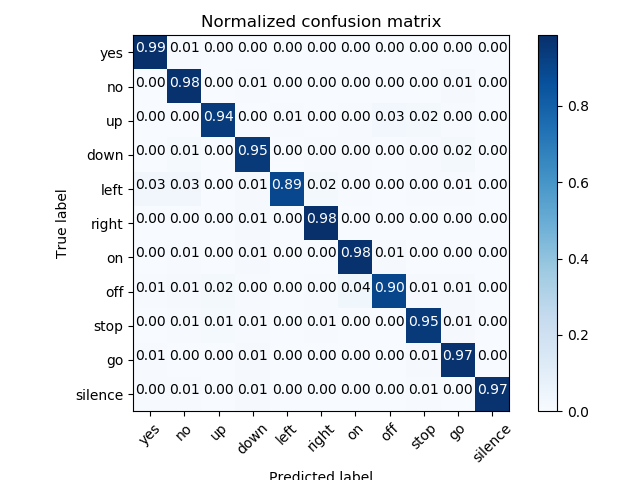

4574/4574 [==============================] - 1s 259us/step
Precision:  95.26 %
Wall time: 13min 4s


In [27]:
%%time
print("\nTINYDARKNET")
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection('tinyDarknet', dataset, labels)

cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.1)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))

functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

Adding augmented dataset
Using optimizer number 0
Train on 54099 samples, validate on 4203 samples
Epoch 1/15
54099/54099 [==============================] - 41s 754us/step - loss: 1.3484 - acc: 0.6723 - top3_acc: 0.8558 - val_loss: 0.4412 - val_acc: 0.8856 - val_top3_acc: 0.9750
Epoch 2/15
54099/54099 [==============================] - 36s 665us/step - loss: 0.3696 - acc: 0.8992 - top3_acc: 0.9748 - val_loss: 0.3260 - val_acc: 0.9163 - val_top3_acc: 0.9803
Epoch 3/15
54099/54099 [==============================] - 36s 666us/step - loss: 0.2743 - acc: 0.9253 - top3_acc: 0.9824 - val_loss: 0.2641 - val_acc: 0.9291 - val_top3_acc: 0.9848
Epoch 4/15
54099/54099 [==============================] - 36s 667us/step - loss: 0.2315 - acc: 0.9372 - top3_acc: 0.9858 - val_loss: 0.2479 - val_acc: 0.9317 - val_top3_acc: 0.9855
Epoch 5/15
54099/54099 [==============================] - 36s 664us/step - loss: 0.1957 - acc: 0.9469 - top3_acc: 0.9870 - val_loss: 0.2295 - val_acc: 0.9419 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


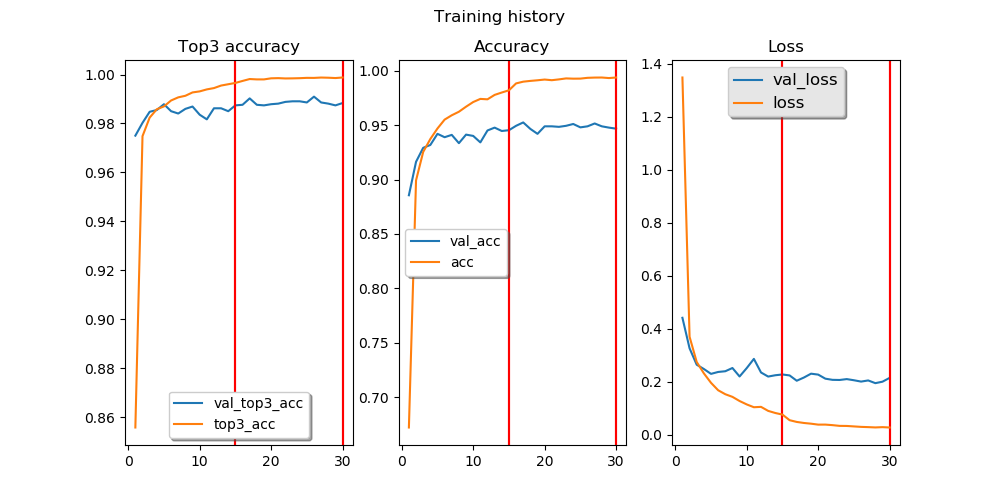

Normalized confusion matrix


<IPython.core.display.Javascript object>


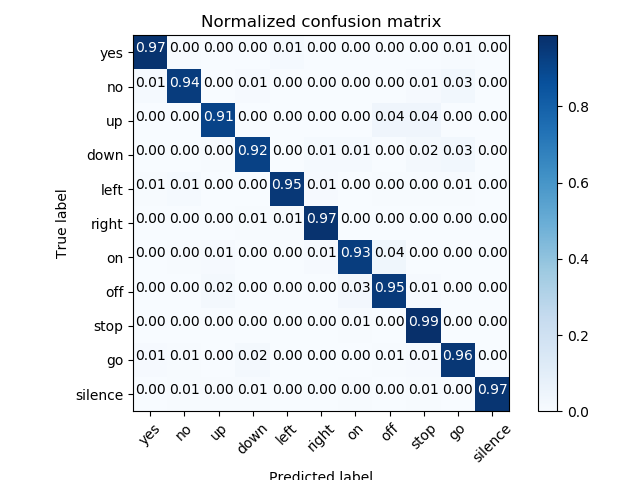

4574/4574 [==============================] - 1s 218us/step
Precision:  95.06 %
Wall time: 17min 52s


In [13]:
%%time
cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.1)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

preds = cnn.predict(testData)

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

name = 'tinyDarknet.bak'
#cnn.save(dest_directory + name)